In [34]:
import io
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

In [35]:
data = pd.read_csv('../../Data/cleaned_v2.csv')

In [36]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
val = pd.read_csv('validation.csv')

In [37]:
X_train, Y_train = train["Content_cleaned_v2"], train["Label"]
X_test, Y_test = test["Content_cleaned_v2"], test["Label"]
X_val, Y_val = val["Content_cleaned_v2"], val["Label"]

In [38]:
Y_train = pd.get_dummies(Y_train)
Y_test = pd.get_dummies(Y_test)
Y_val = pd.get_dummies(Y_val)

In [39]:
# from keras_preprocessing.text import Tokenizer
# import pickle
# from keras_preprocessing.sequence import pad_sequences

# tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')

# tokenizer.fit_on_texts(X_train)
# sequences = tokenizer.texts_to_sequences(X_train)
# with open('tokenizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f)


In [40]:
from gensim.models import Word2Vec, KeyedVectors
w2v = Word2Vec.load("../../FeatureEngineering/Vectorize/w2vmodel_skip_64.model")

In [41]:
import pickle
tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))

In [42]:
import numpy as np
notin = []
embedding_dim = 64
maxlen = 350
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
print('num_words:', num_words)
for word, i in word_index.items():
    if word in w2v.wv.key_to_index:
            embedding_matrix[i] = w2v.wv[word]
    else:
        notin.append(word)

num_words: 57132


In [43]:
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
    
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'att': self.att,
            'ffn': self.ffn,
            'layernorm1': self.layernorm1,
            'layernorm2': self.layernorm2,
            'dropout1': self.dropout1,
            'dropout2': self.dropout2,
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    

In [44]:
 # Two seperate embedding layers, one for tokens, one for token index (positions)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim, num_words, embedding_matrix):
        super().__init__()
        self.token_emb = layers.Embedding(num_words, output_dim=embed_dim, input_length=maxlen,weights=embedding_matrix,trainable=False)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'token_emb': self.token_emb,
            'pos_emb': self.pos_emb,
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [52]:
embed_dim = 64  # Embedding size for each token
num_heads = 10    # Number of attention heads
ff_dim = 128    # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen,  embed_dim, num_words, [embedding_matrix])
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(9, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 350)]             0         
                                                                 
 token_and_position_embeddin  (None, 350, 64)          3678848   
 g_3 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_3 (Transf  (None, 350, 64)          182656    
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_3   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_14 (Dropout)        (None, 64)                0   

In [53]:
from keras_preprocessing import sequence
X_train1 = tokenizer.texts_to_sequences(X_train)
X_train2 = sequence.pad_sequences(X_train1, maxlen)

In [54]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_trans_skip_64.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [56]:
X_val1 = tokenizer.texts_to_sequences(X_val)
X_val2 = sequence.pad_sequences(X_val1, maxlen)

In [57]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0075), loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train2, Y_train, batch_size=64, epochs=30, validation_data=(X_val2, Y_val), callbacks=[early_stopping, checkpoint])

Epoch 1/30
249/249 [==============================] - ETA: 0s - loss: 0.5689 - accuracy: 0.8170
Epoch 1: val_loss improved from inf to 0.35606, saving model to best_trans_skip_64.h5
249/249 [==============================] - 484s 2s/step - loss: 0.5689 - accuracy: 0.8170 - val_loss: 0.3561 - val_accuracy: 0.8980
Epoch 2/30
249/249 [==============================] - ETA: 0s - loss: 0.3398 - accuracy: 0.8915
Epoch 2: val_loss improved from 0.35606 to 0.29051, saving model to best_trans_skip_64.h5
249/249 [==============================] - 436s 2s/step - loss: 0.3398 - accuracy: 0.8915 - val_loss: 0.2905 - val_accuracy: 0.9115
Epoch 3/30
249/249 [==============================] - ETA: 0s - loss: 0.2863 - accuracy: 0.9083
Epoch 3: val_loss did not improve from 0.29051
249/249 [==============================] - 446s 2s/step - loss: 0.2863 - accuracy: 0.9083 - val_loss: 0.3496 - val_accuracy: 0.8865
Epoch 4/30
249/249 [==============================] - ETA: 0s - loss: 0.2629 - accuracy: 0.91

KeyboardInterrupt: 

In [ ]:
X_test1 = tokenizer.texts_to_sequences(X_test)
X_test2 = sequence.pad_sequences(X_test1, maxlen)

In [ ]:
loss, accuracy = model.evaluate(X_test2, Y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

214/214 [==============================] - 96s 450ms/step - loss: 0.3516 - accuracy: 0.9018
Test Loss: 0.35159367322921753
Test Accuracy: 0.9017595052719116


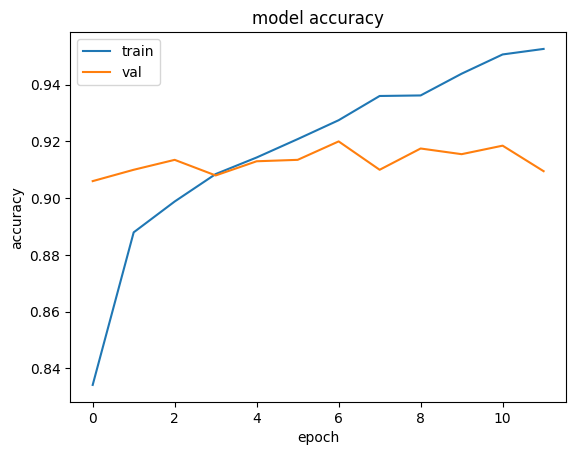

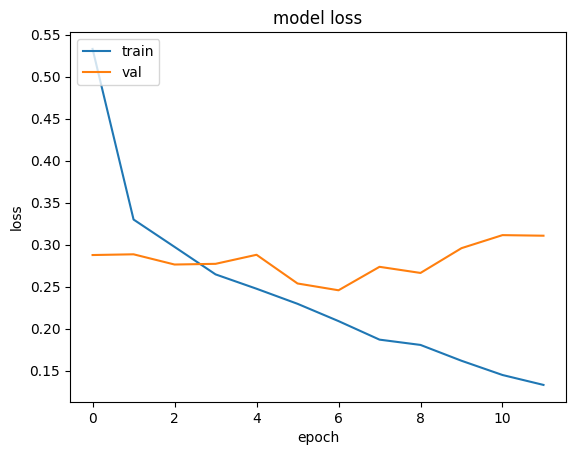

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()